In [1]:
from importlib import reload
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import analyze
import raybay

In [42]:
# Load treatment plan results
sample = np.load('sample/res_linear_dummy_minimize.pkl', allow_pickle=True)

In [3]:
sample.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Chestwall_L,MaxDvh,AtMost,3000,2.04
1,D2cm,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,16.91
3,Lungs,MaxDvh,AtMost,1160,29.19
4,Lungs,MaxDvh,AtMost,1240,19.46
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Rib,MaxDvh,AtMost,3200,0.27
8,Rib,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,2.30


In [4]:
sample.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Chestwall_L,MaxDvh,"[0,3000]",2.04,NaN,1
1,D2cm,MaxDose,"[0,2400]",0.00,NaN,1
2,Esophagus,MaxDvh,"[0,1880]",16.91,NaN,1
3,Lungs,MaxDvh,"[0,1160]",29.19,NaN,1
4,Lungs,MaxDvh,"[0,1240]",19.46,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,"[4801,8000]",0.00,NaN,1
7,Rib,MaxDvh,"[0,3200]",0.27,NaN,1
8,Rib,MaxDose,"[0,4000]",0.00,NaN,1
9,SpinalCanal,MaxDvh,"[0,1360]",2.30,NaN,1


In [ ]:
# Plots for all flags

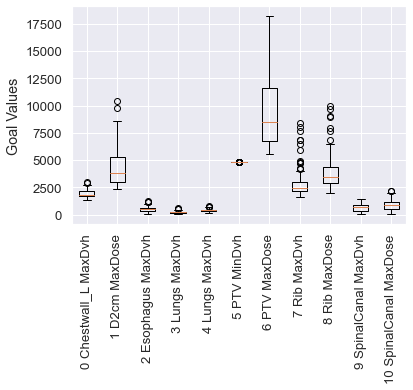

In [92]:
sample.boxplot('goals')

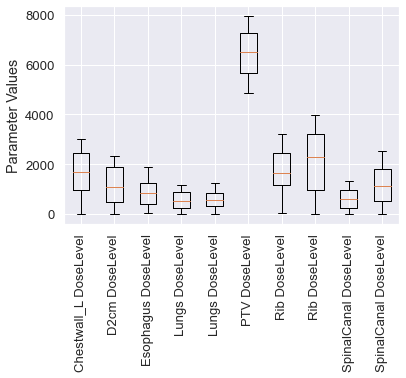

In [93]:
sample.boxplot('pars')

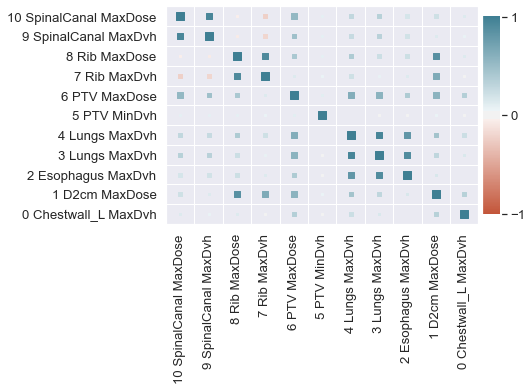

In [94]:
sample.corrplot('goals')

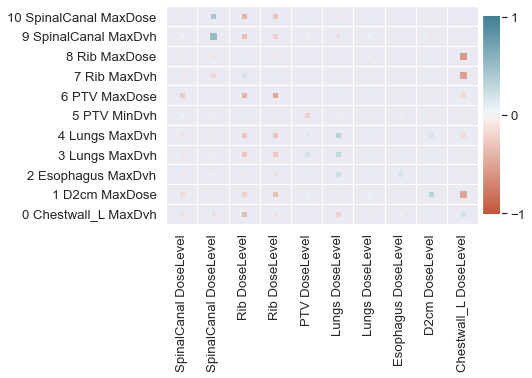

In [95]:
sample.corrplot('pars')

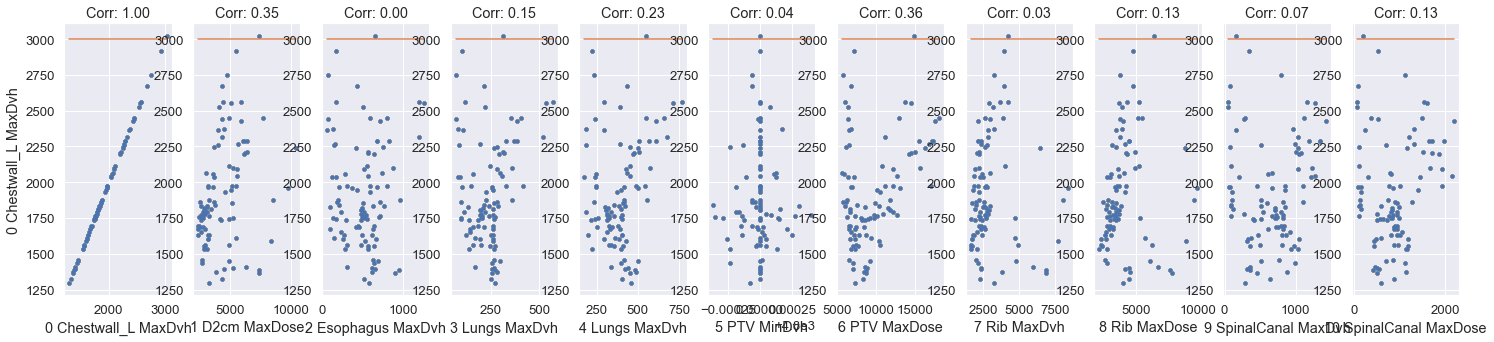

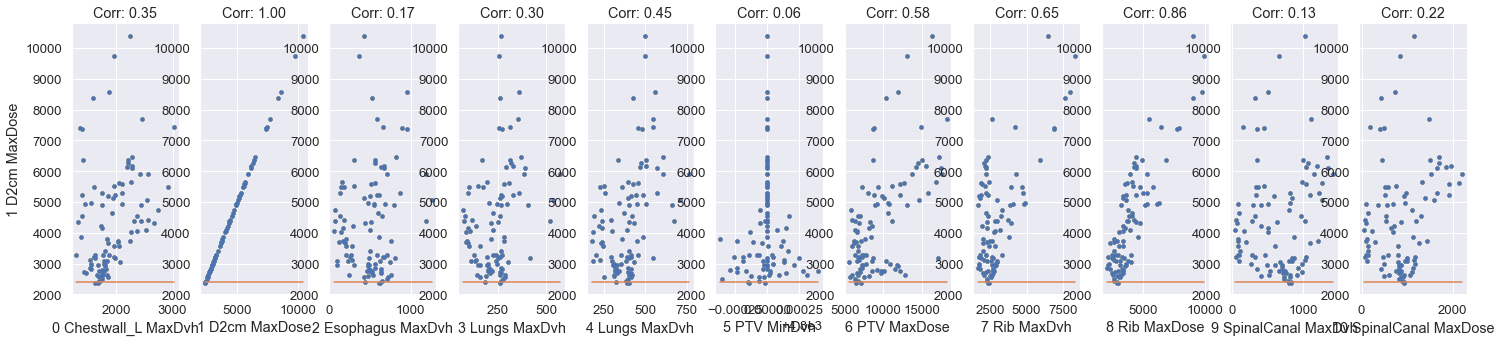

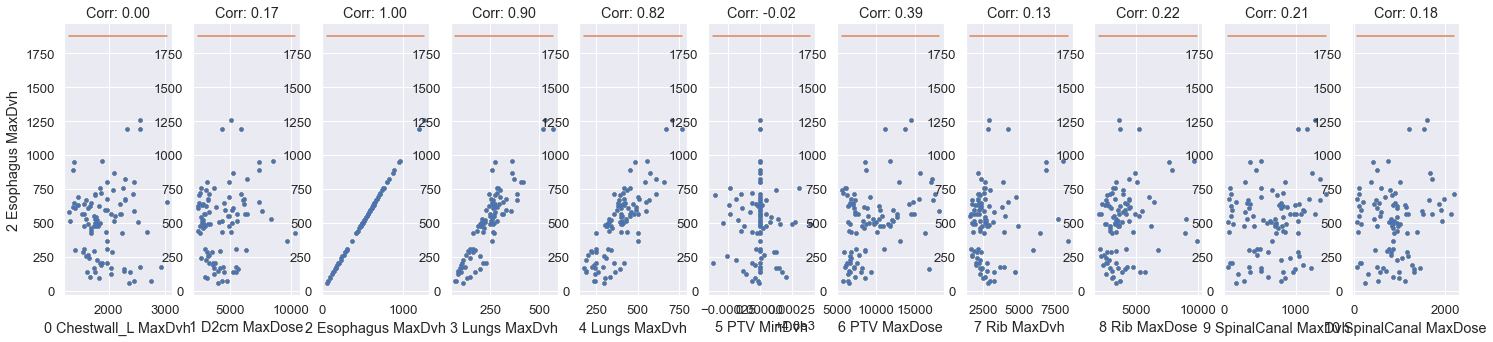

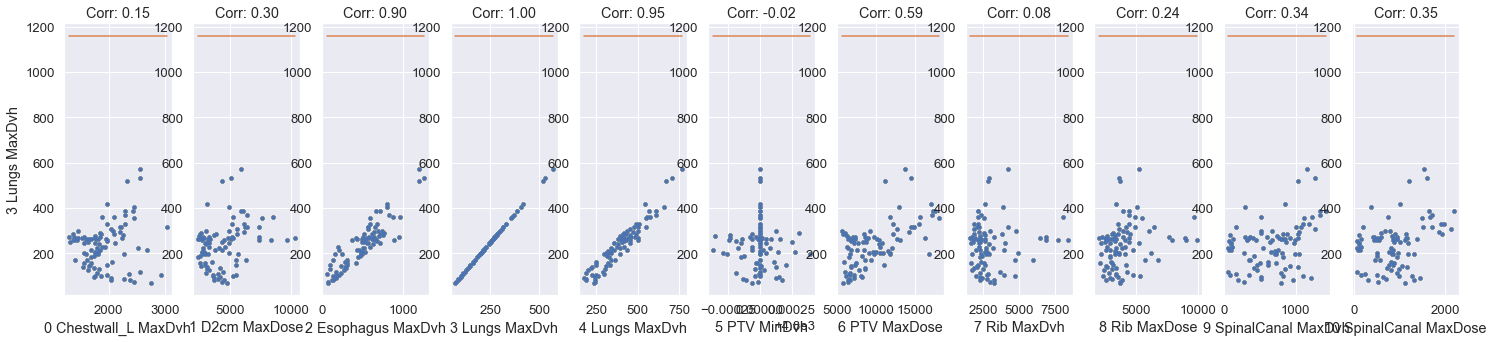

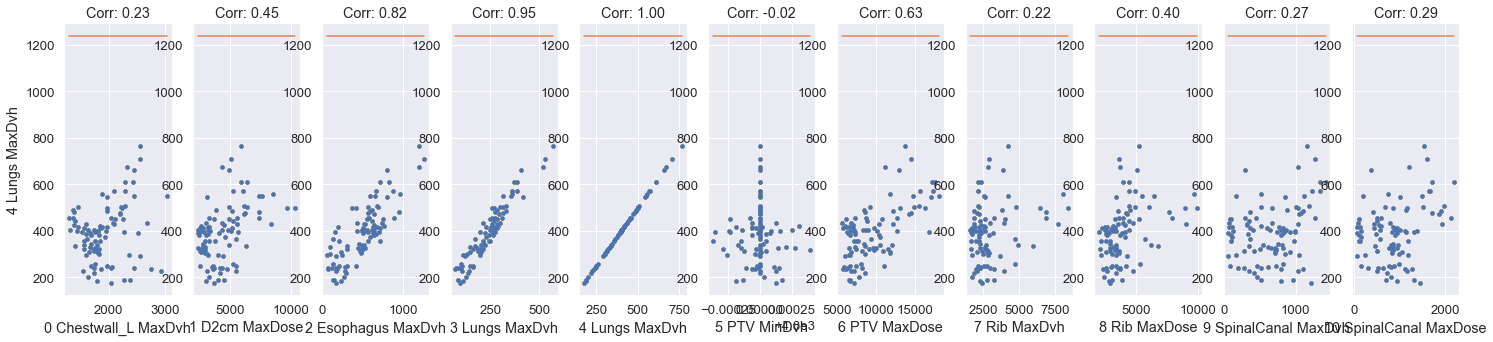

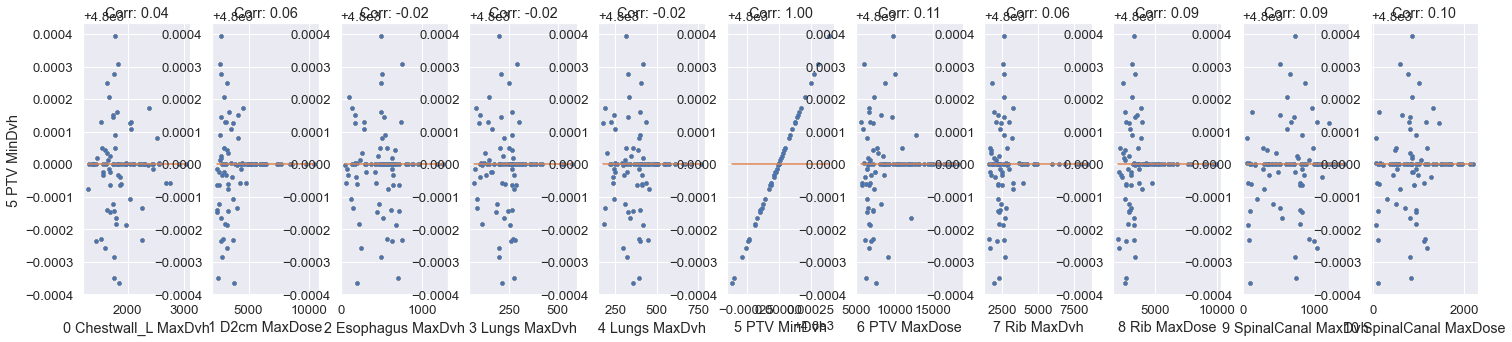

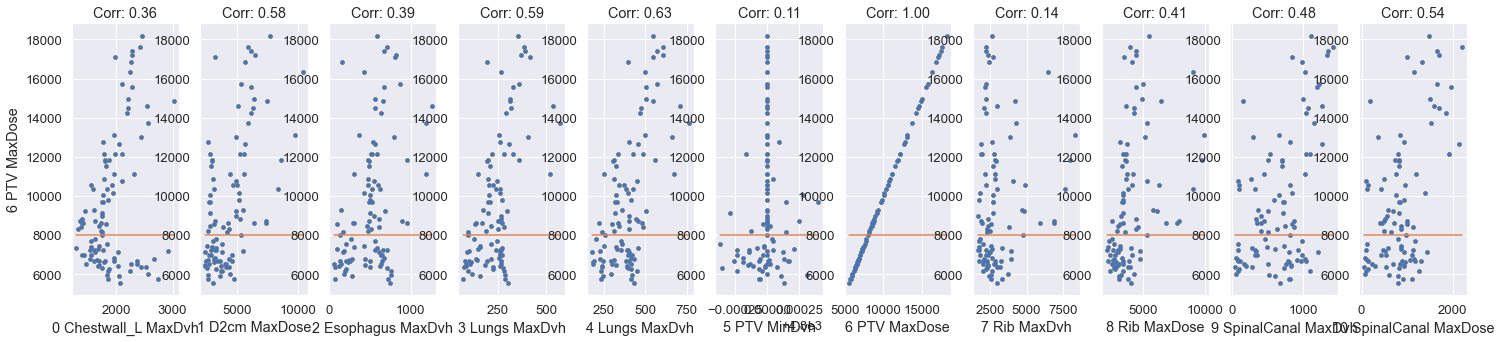

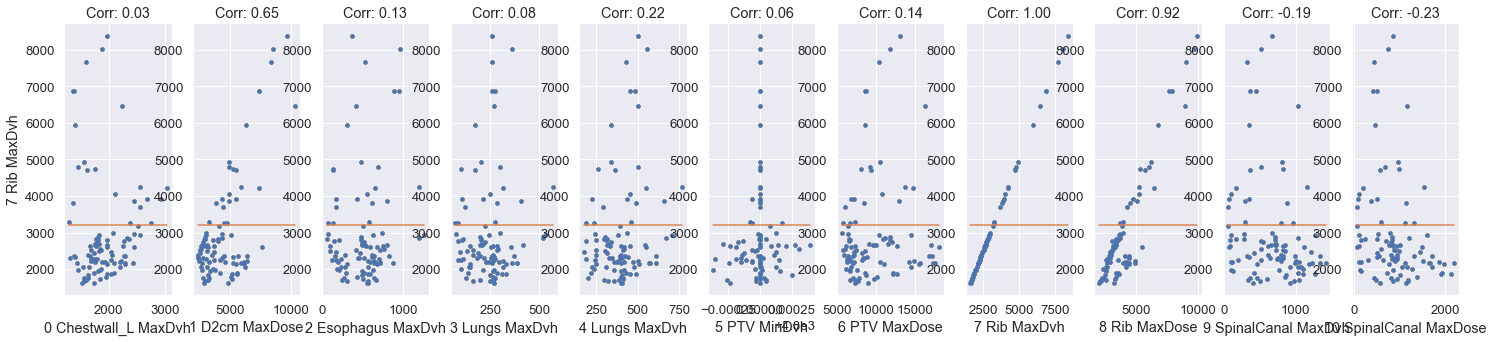

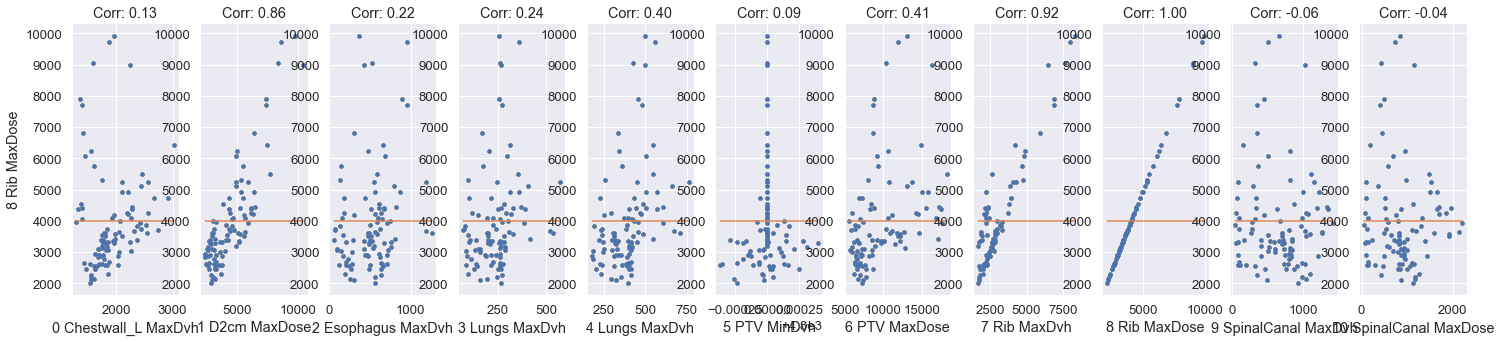

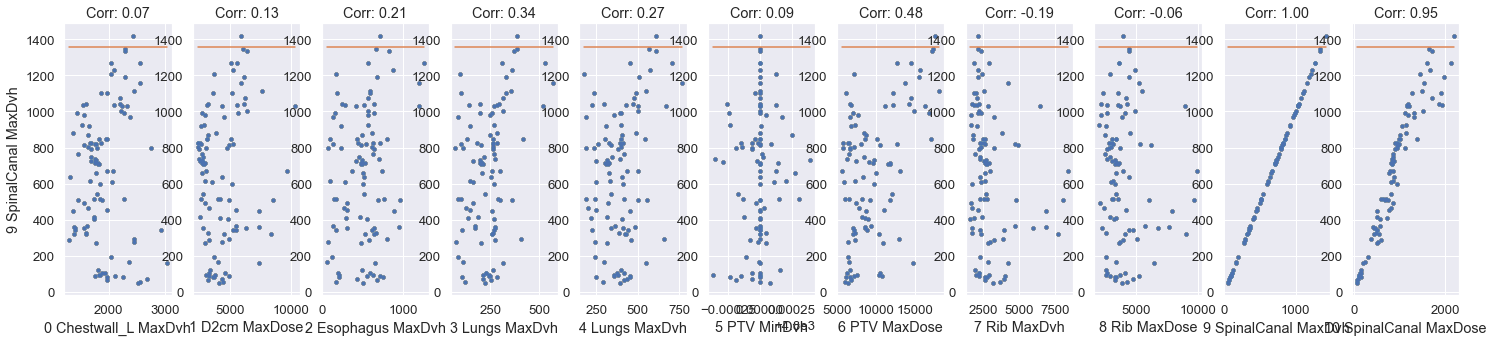

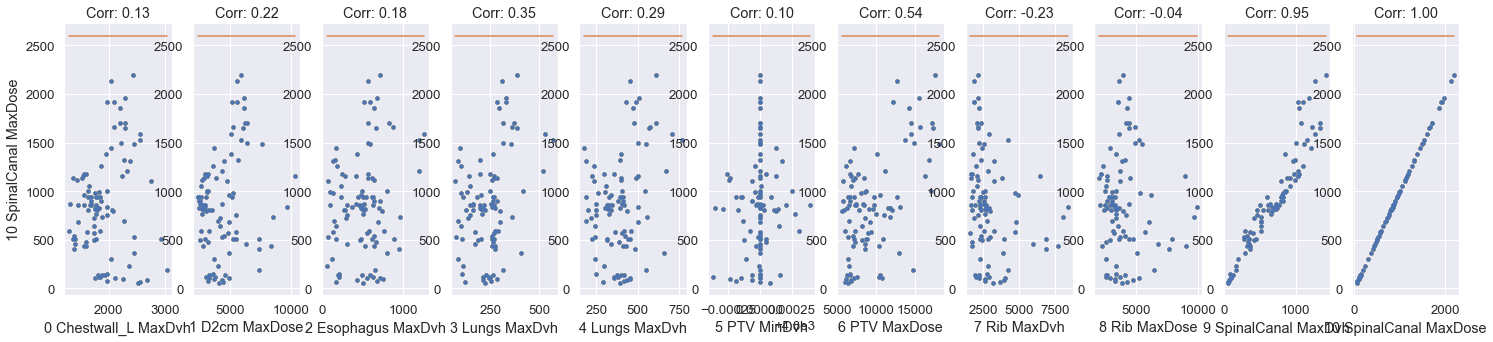

In [96]:
sample.scatterplot('goals')

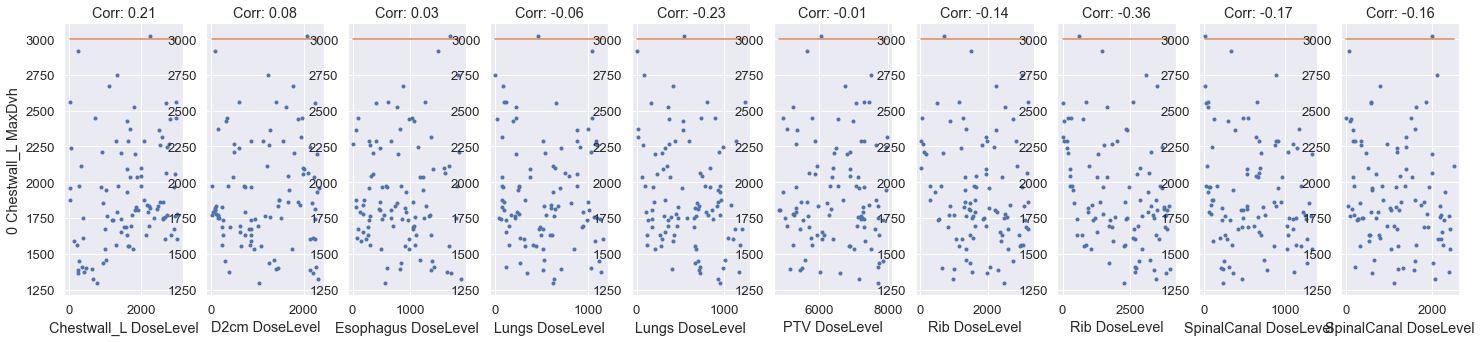

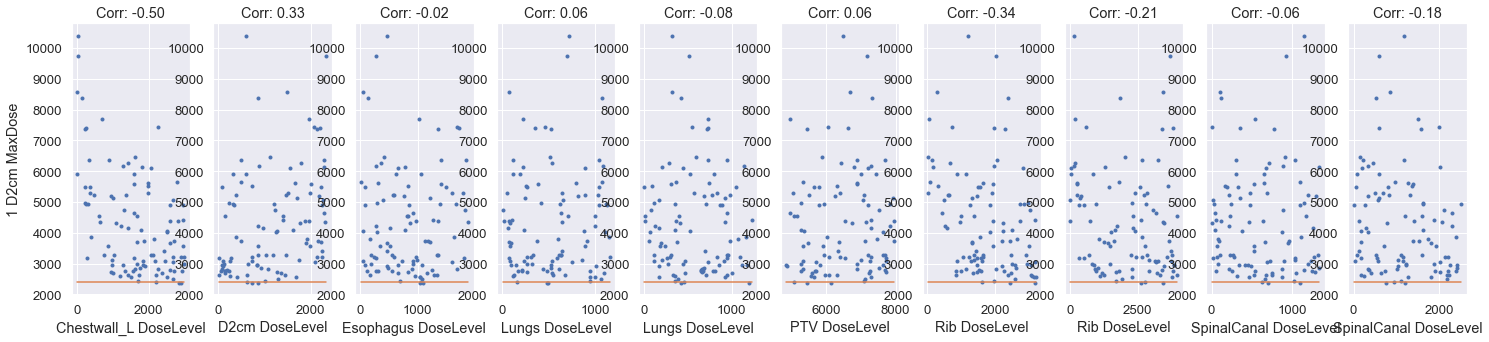

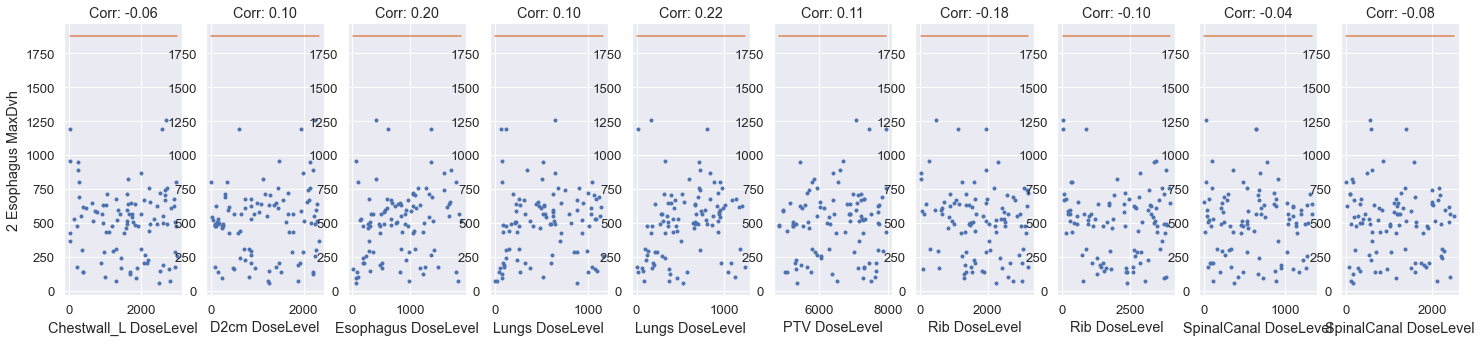

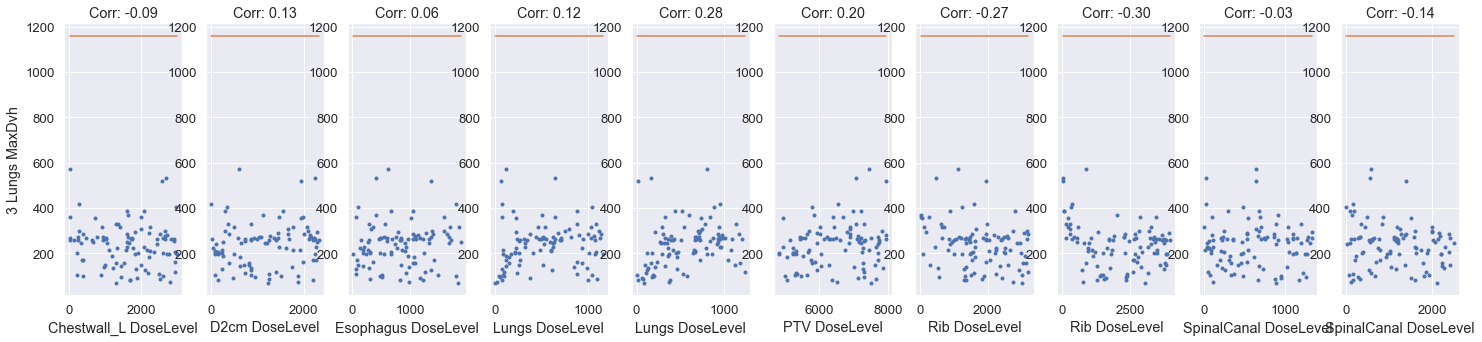

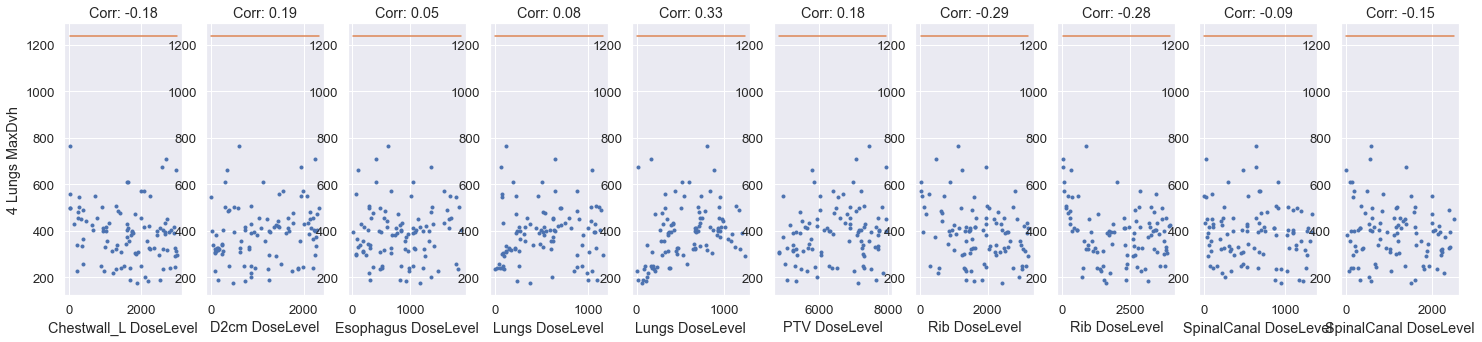

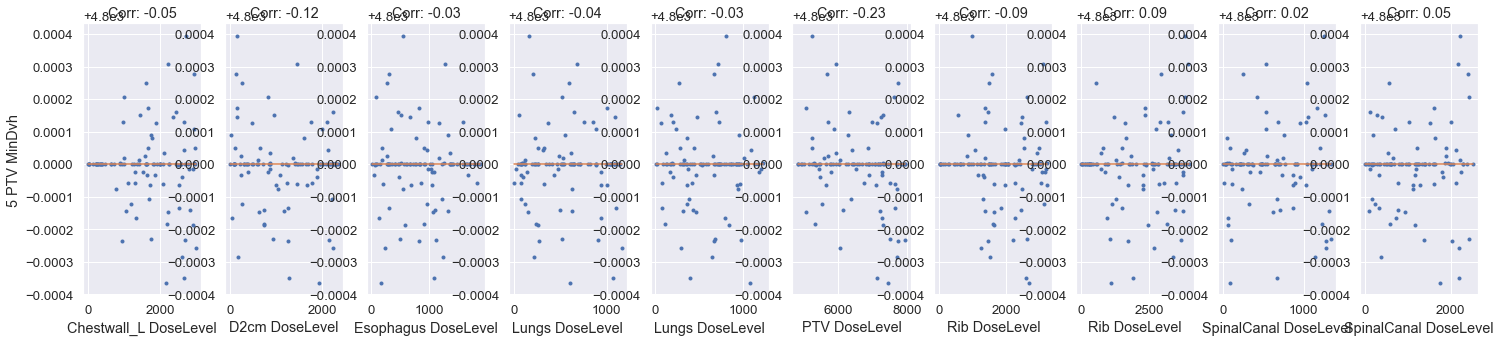

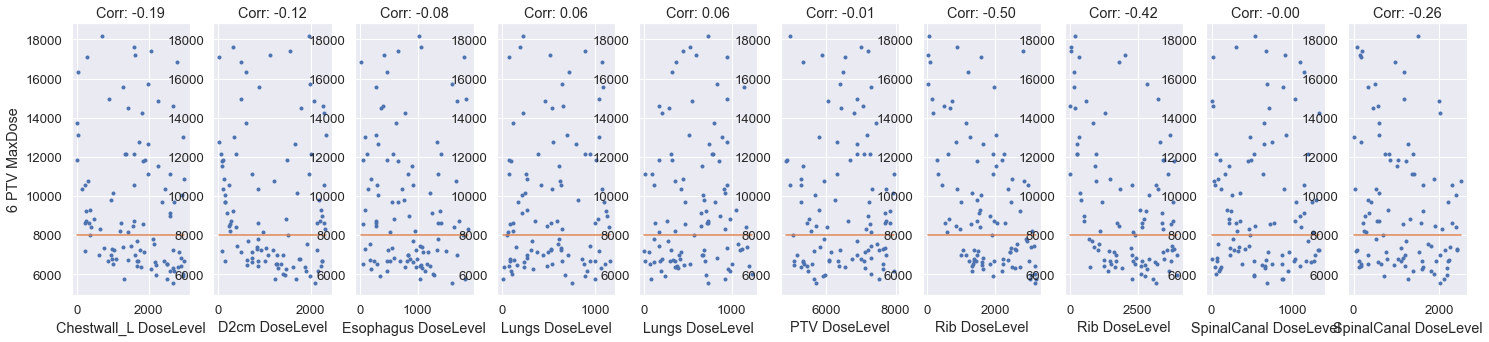

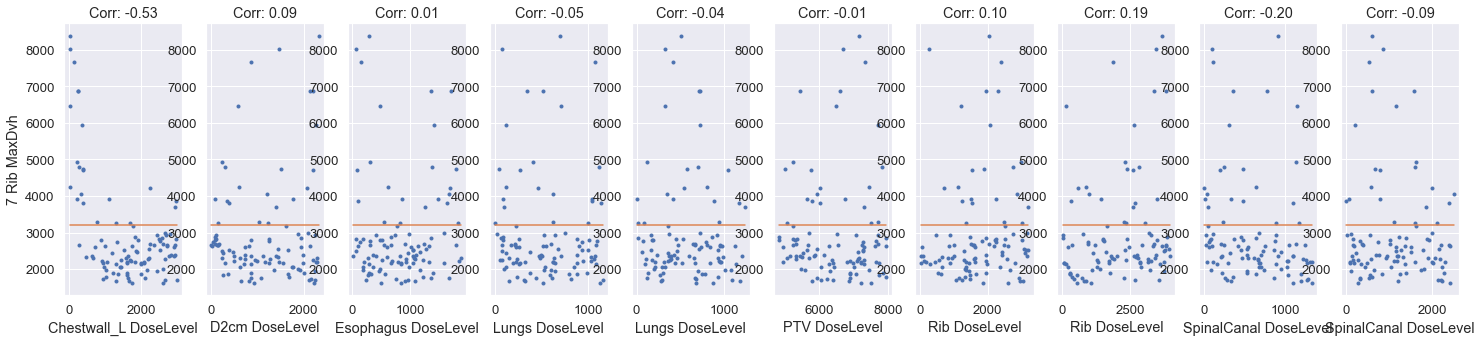

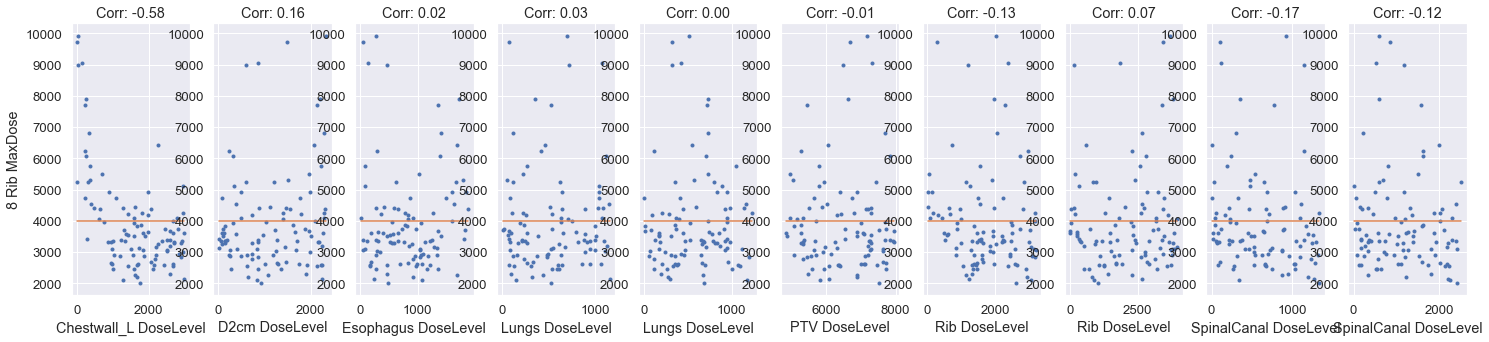

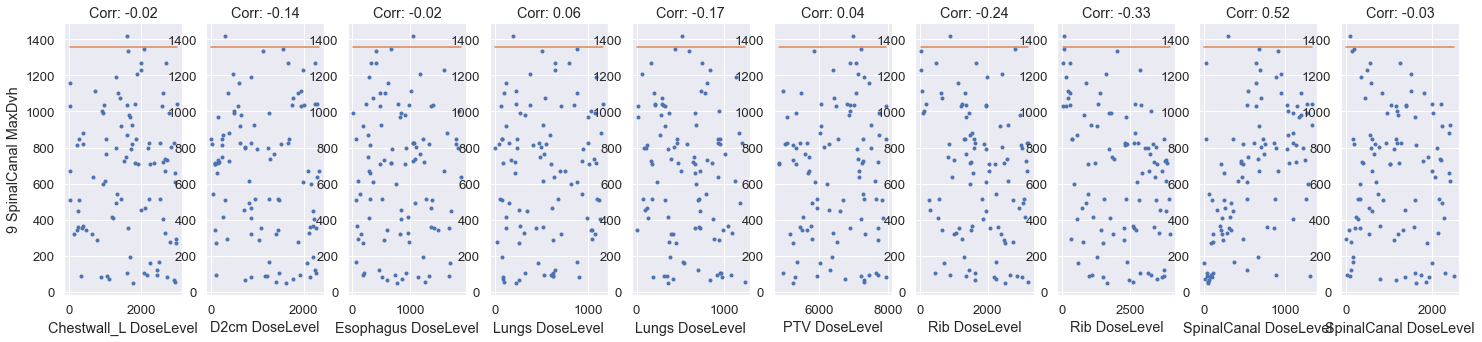

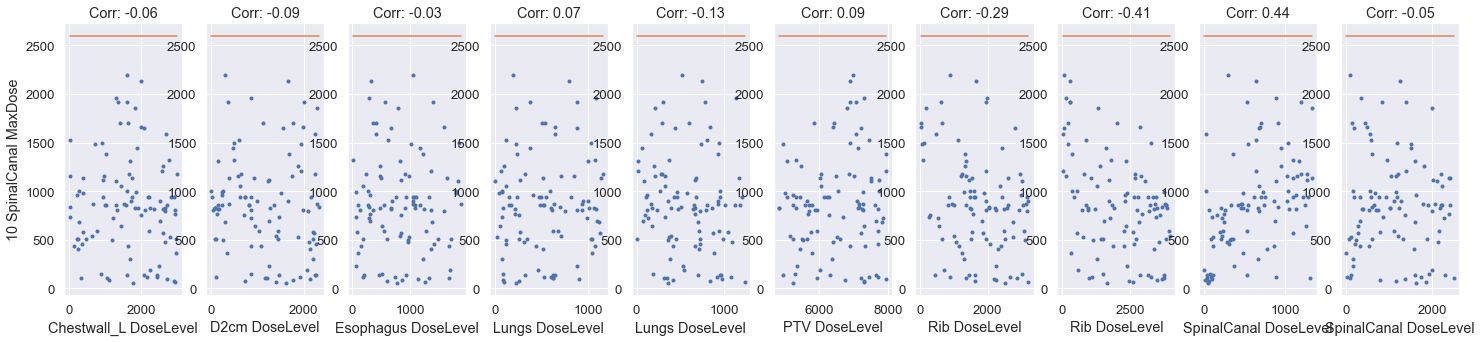

In [100]:
sample.scatterplot('pars')

In [ ]:
# Filter by flag = 0

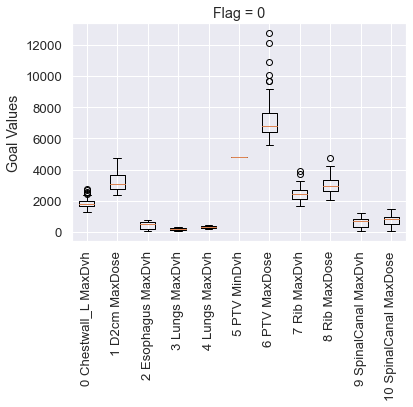

In [124]:
idx_0 = np.where(np.array(sample.flag_list) == 0)[0]
goal_dict = {ii: np.array(sample.goal_dict[ii])[idx_0] for ii in sample.goal_dict}
analyze.boxplot(sample.goal_df, goal_dict, 'goals', title='Flag = 0')

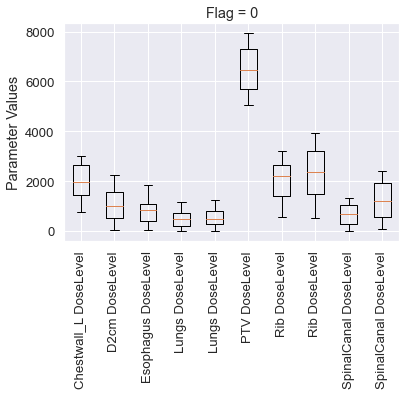

In [118]:
par_list = np.array(sample.opt_result.x_iters)[idx_0,:]
analyze.boxplot(sample.func_df, par_list, 'pars', title='Flag = 0')

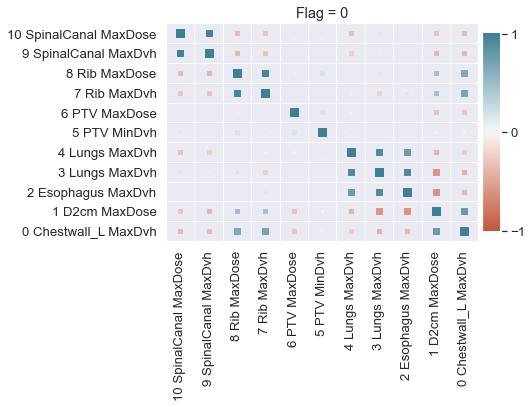

In [125]:
analyze.corrplot(sample.goal_df, goal_dict, title='Flag = 0')

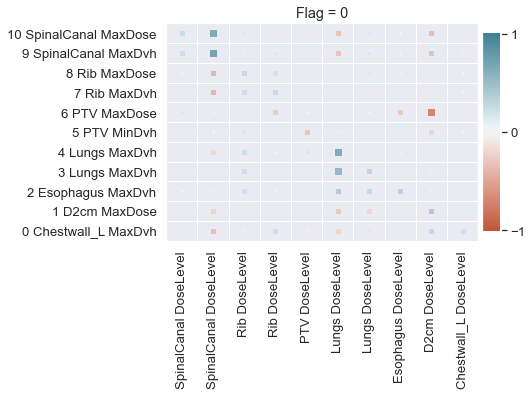

In [127]:
analyze.corrplot(sample.goal_df, goal_dict, sample.func_df, par_list, title='Flag = 0')

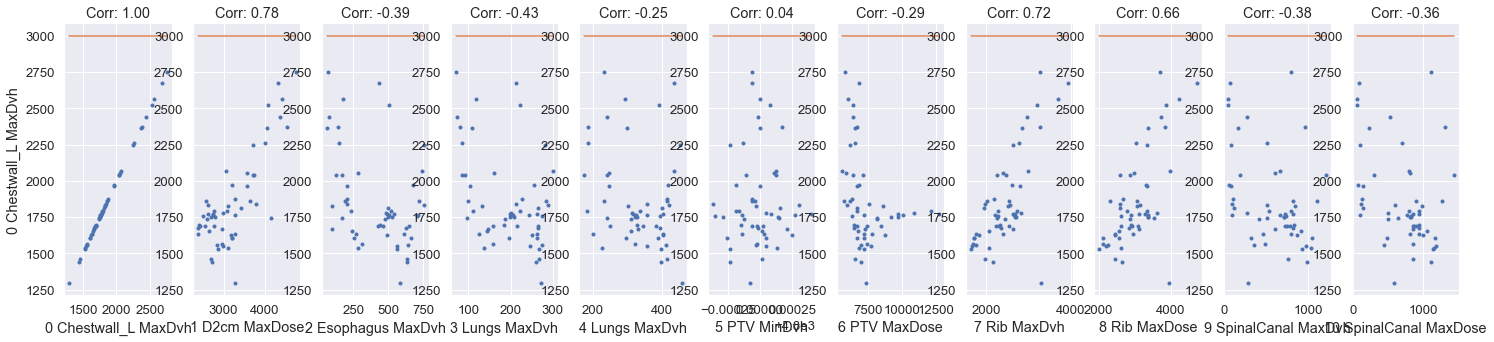

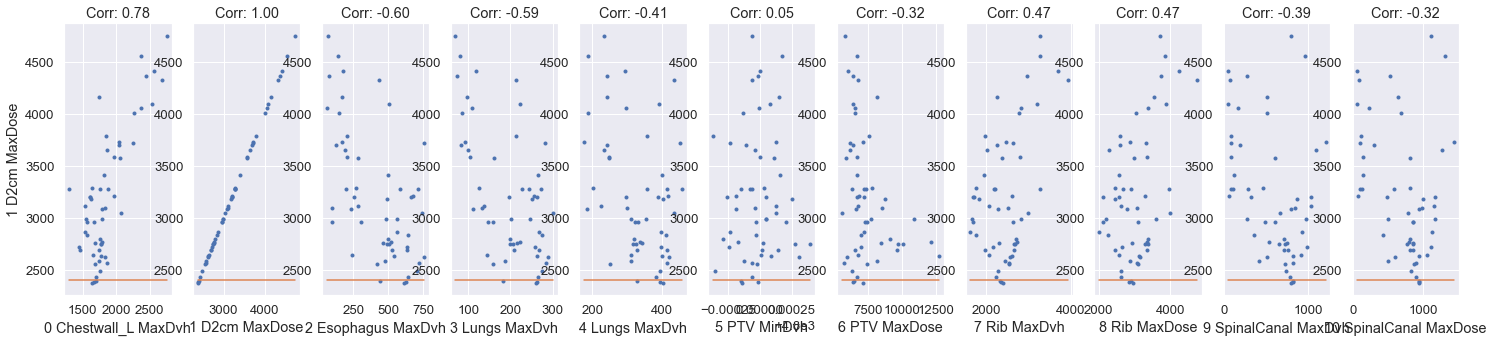

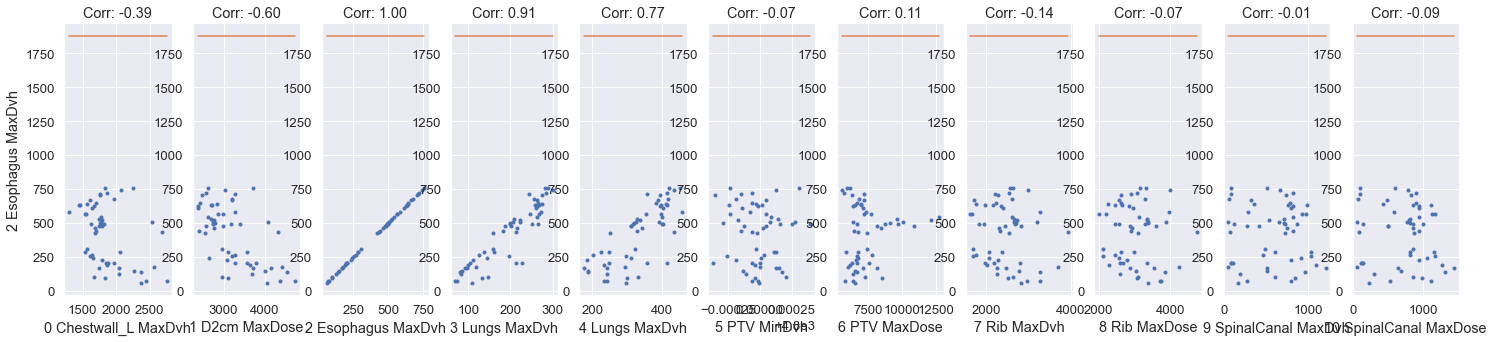

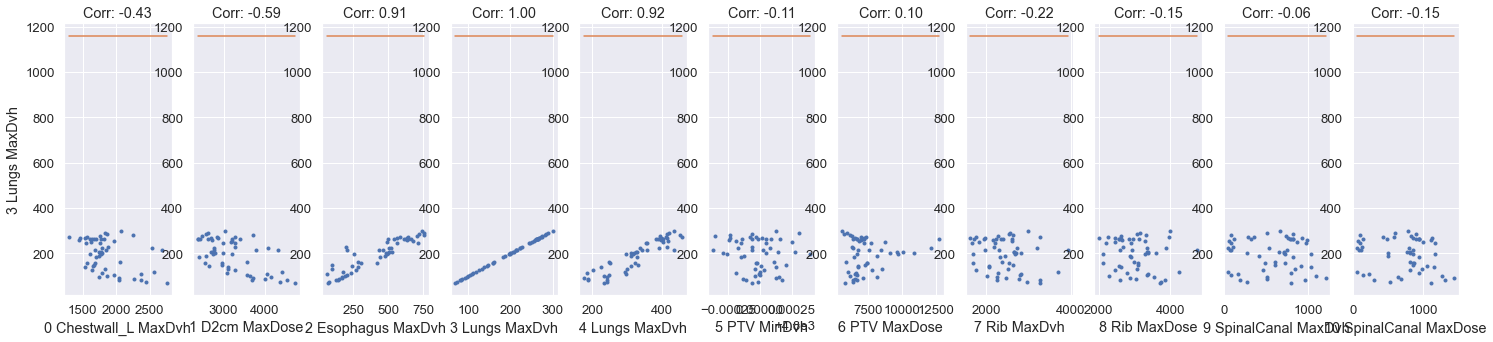

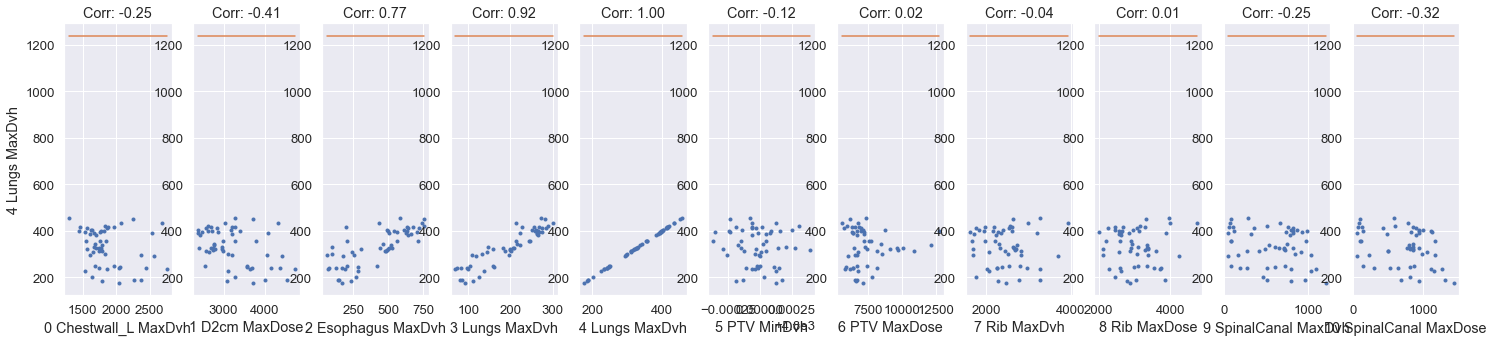

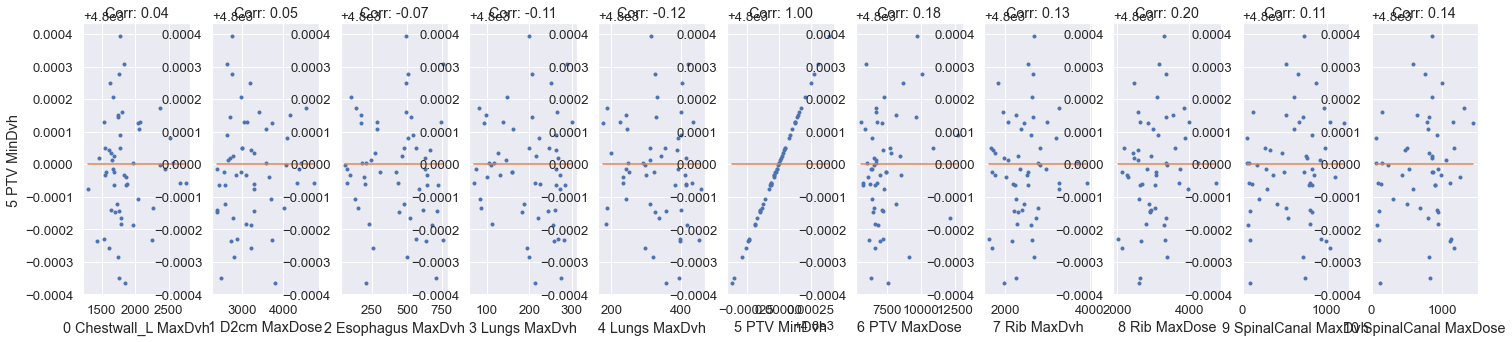

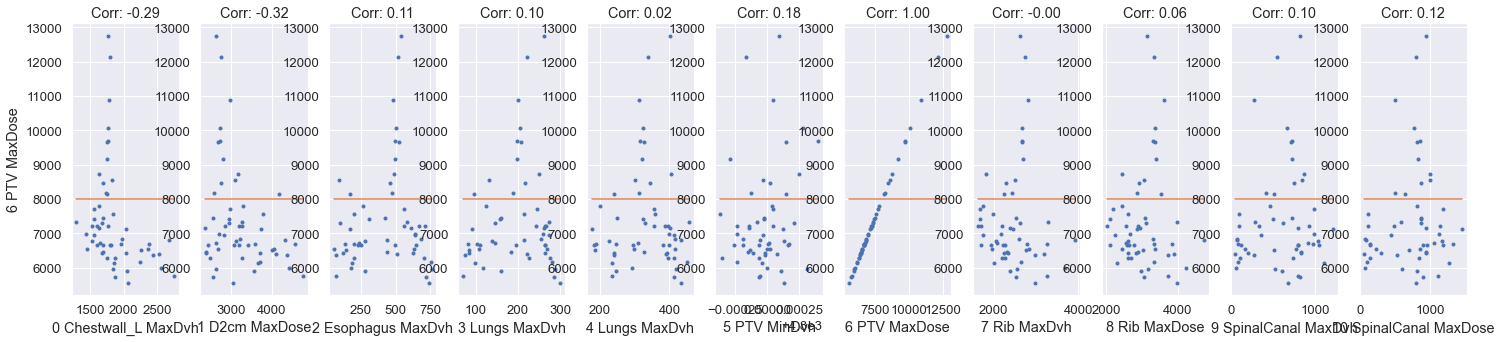

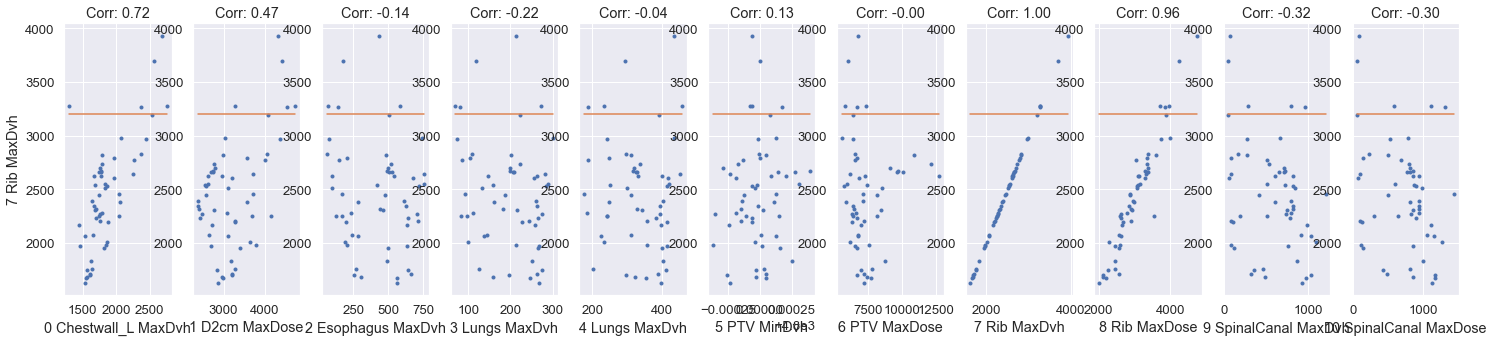

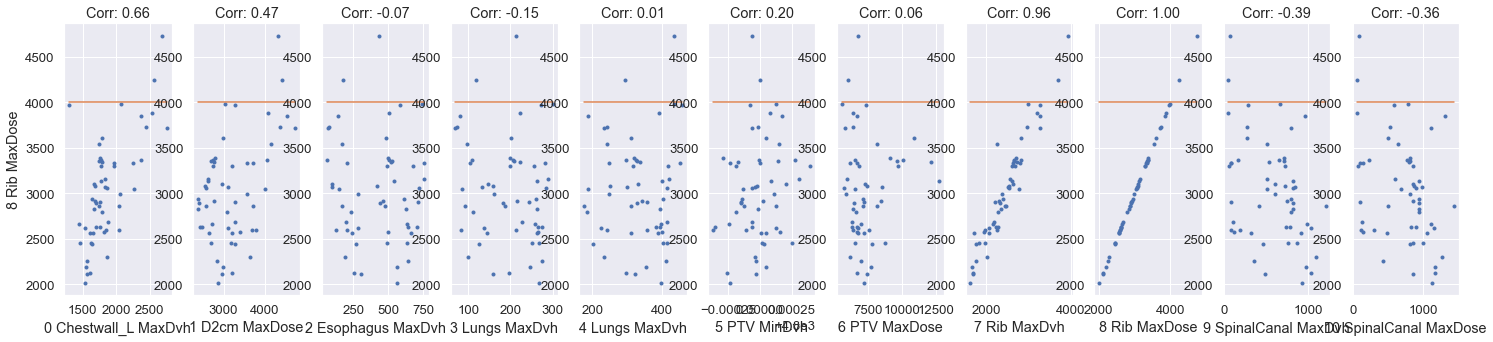

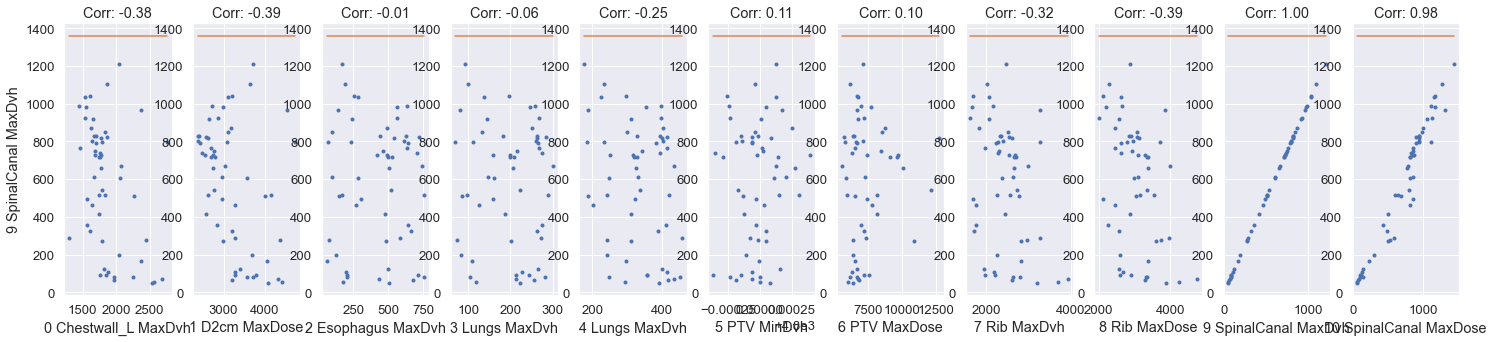

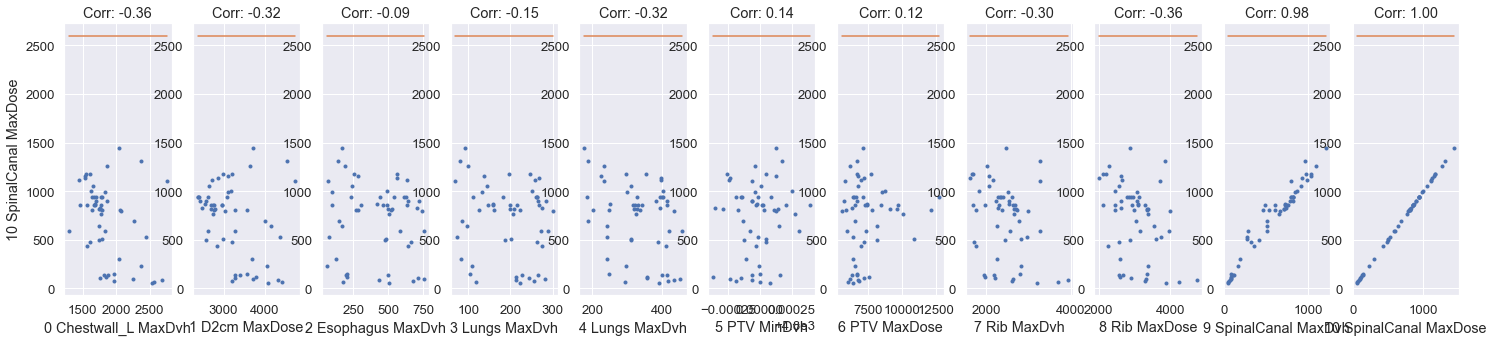

In [128]:
analyze.scatterplot(sample.goal_df, goal_dict)

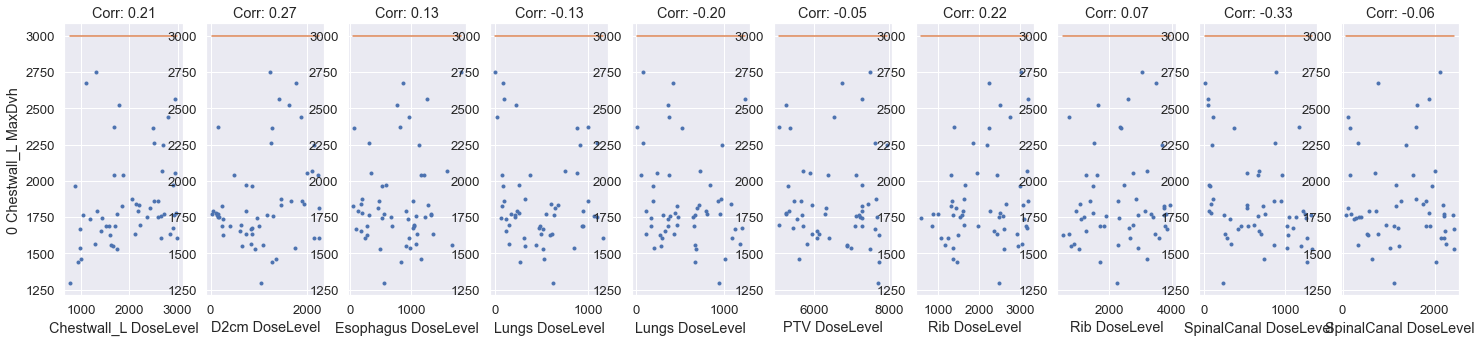

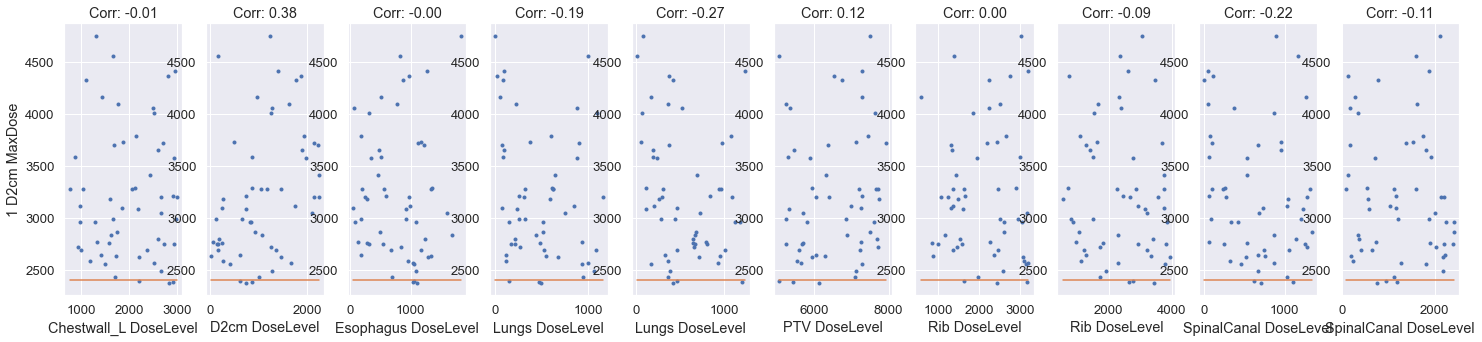

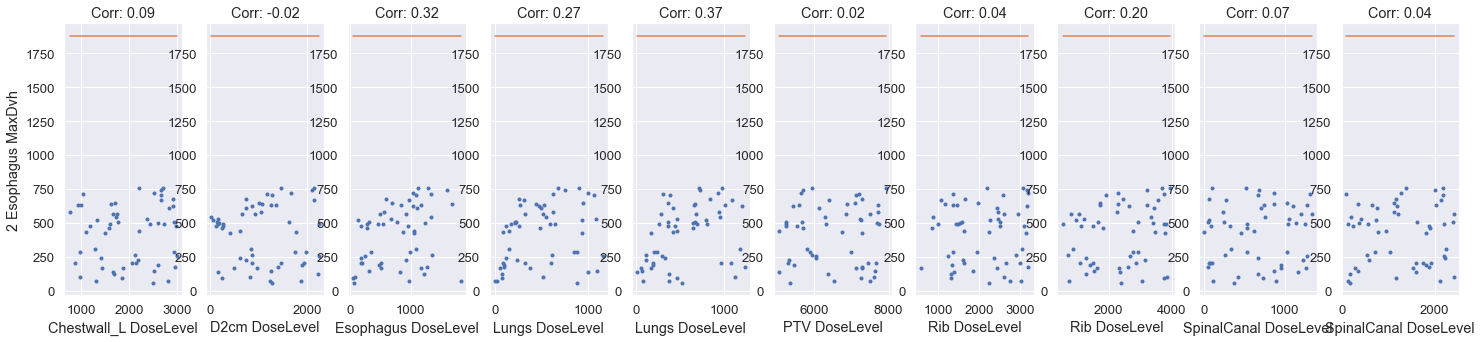

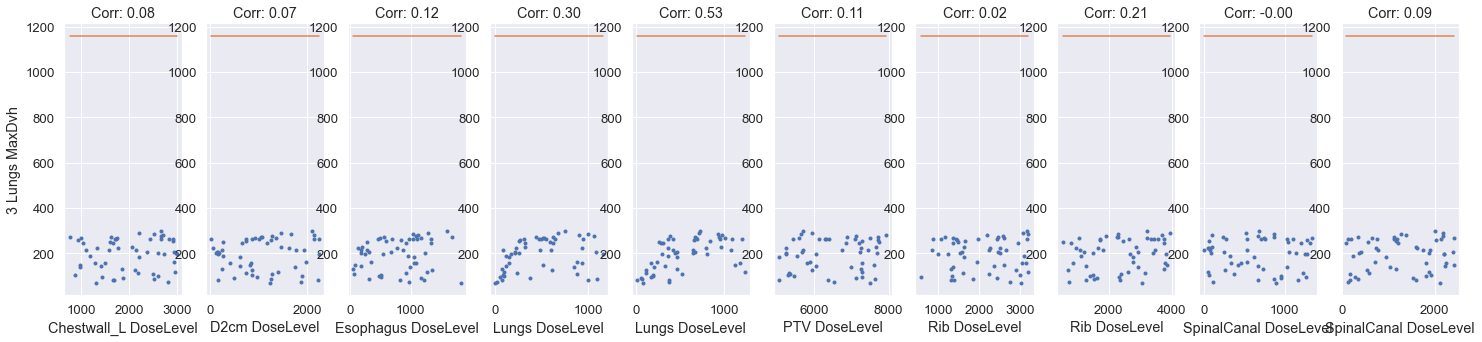

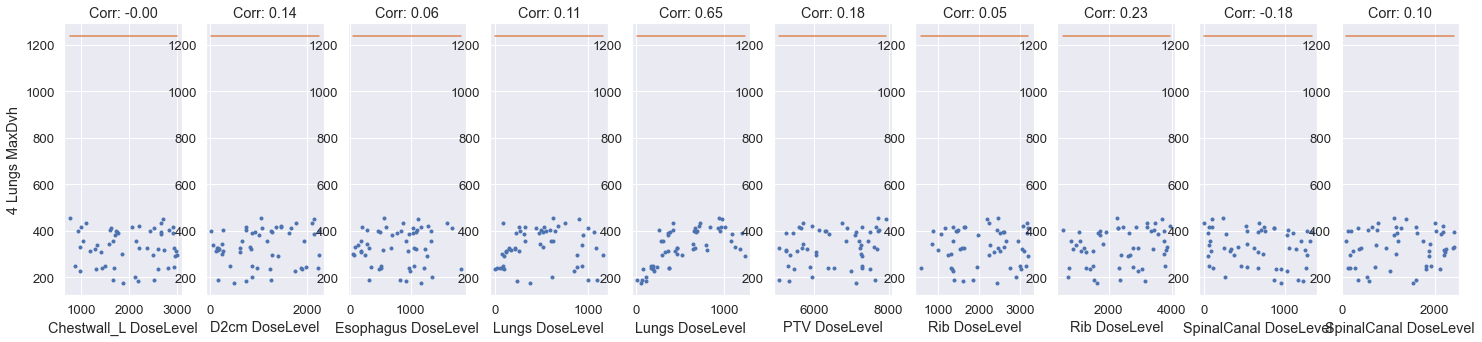

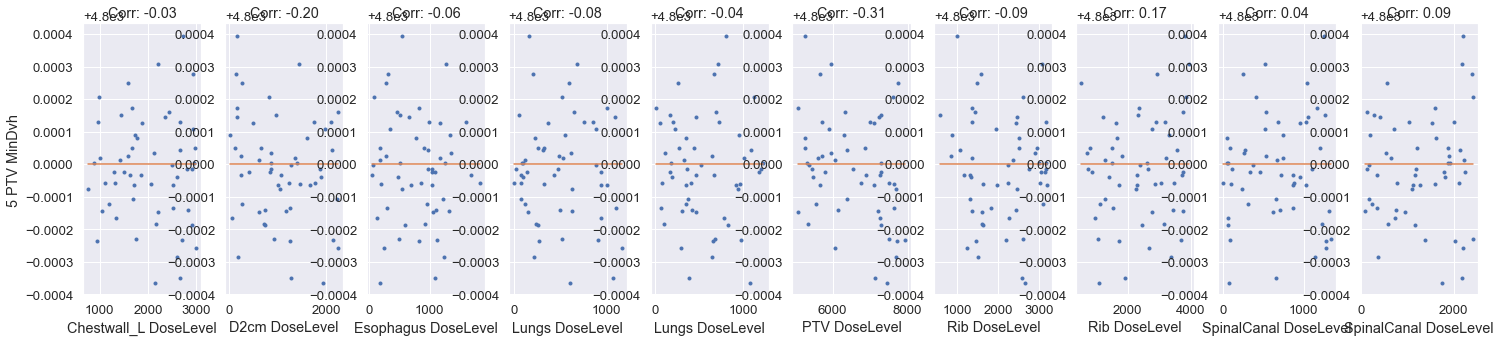

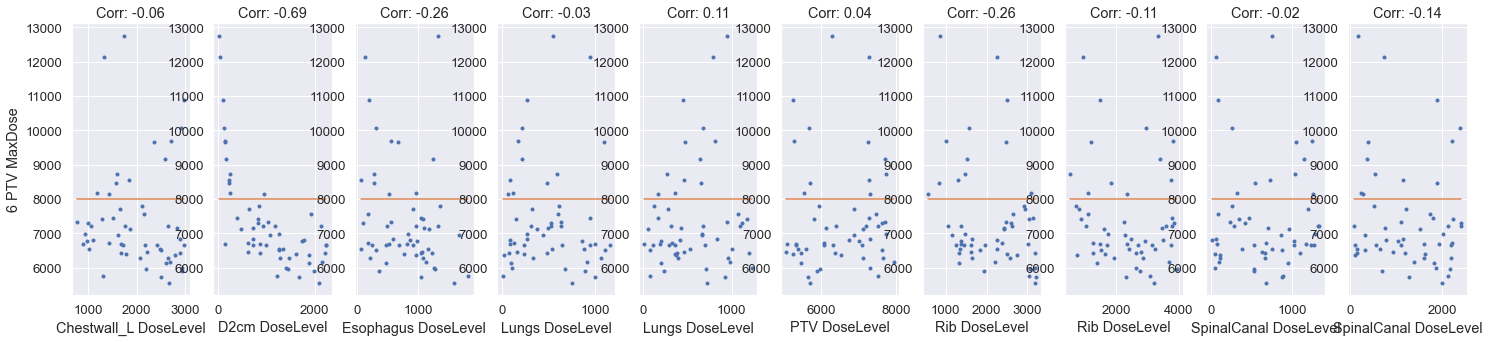

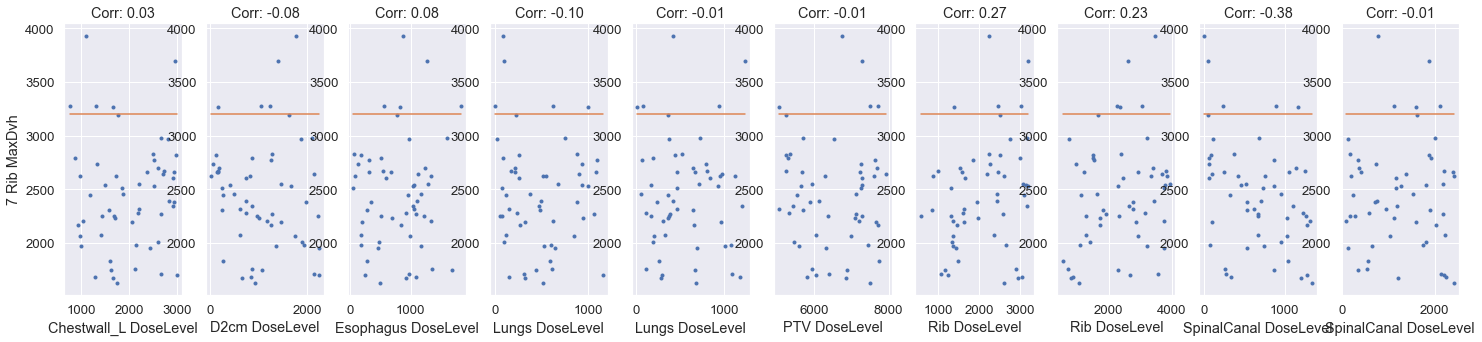

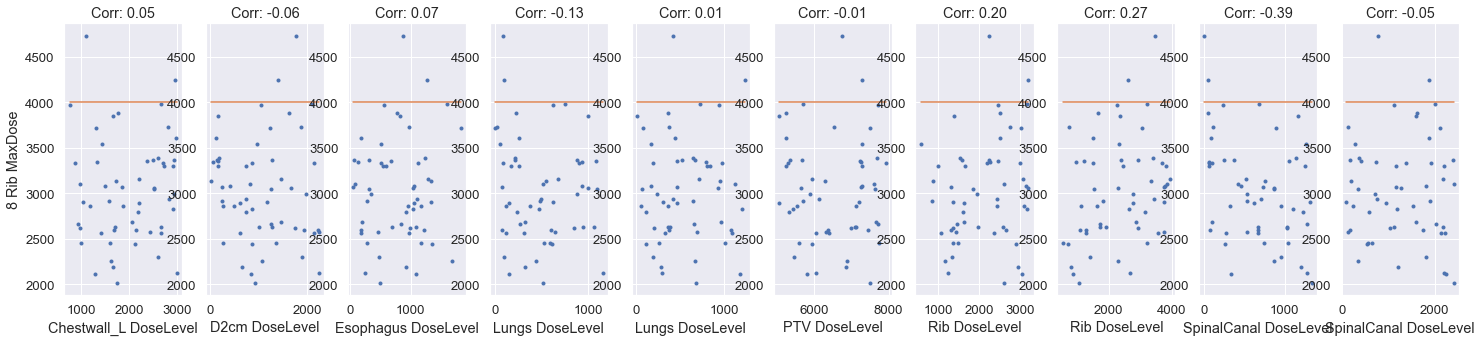

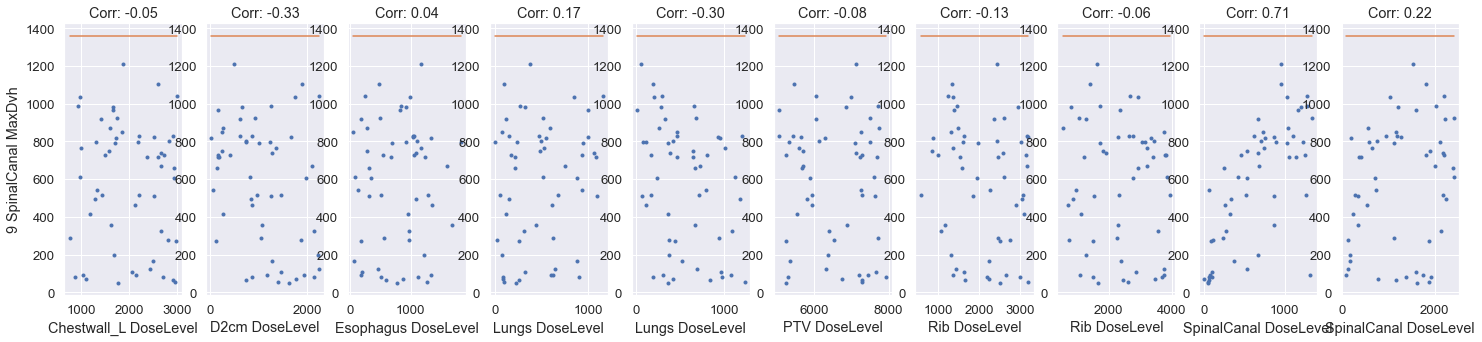

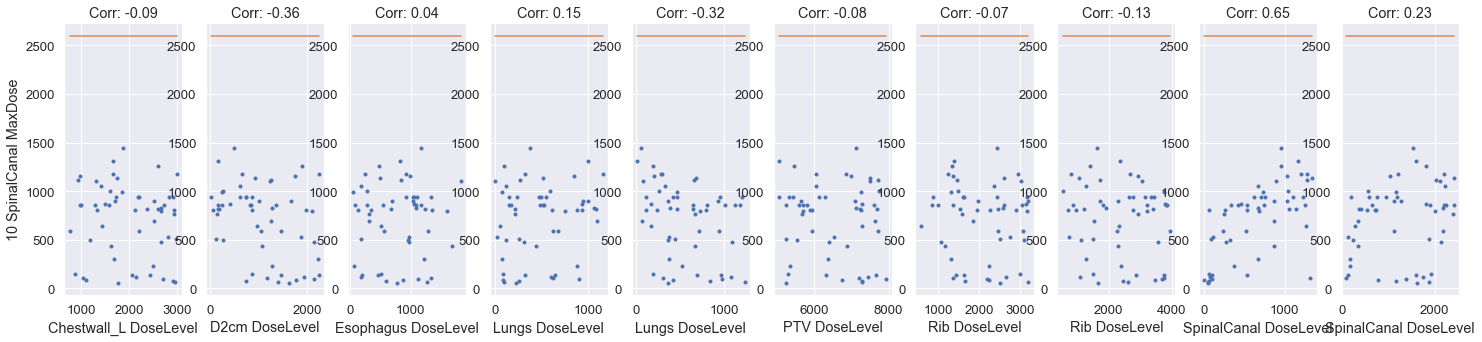

In [129]:
analyze.scatterplot(sample.goal_df, goal_dict, sample.func_df, par_list)

In [130]:
# TODO: Try filtering by goal values or parameter values

In [131]:
# TODO: corrplot with clustering

In [132]:
# TODO: goalplot with different utility functions for samples